In [1]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import pyro
import pyro.distributions as dist
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.express as px
import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
reference_file = "../../data/pbmc/sc.h5ad"
bulk_file = "../../data/pbmc/bulk.tsv"
cell_types = [
    'T CD4', 'Monocytes',
    'B cells', 'T CD8',
    'NK', 'Monocytes',
    'unknown', 'unknown']
true_df = pd.read_csv("../../data/pbmc/true.tsv", sep="\t", index_col=0)
true_df = true_df.reindex(sorted(true_df.columns), axis=1)

In [3]:
sadata = sc.read_h5ad(reference_file)
sadata.X = sadata.X.astype("float32").toarray()
sadata.var.set_index("gene_ids", inplace=True)

sadata = sadata[sadata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(sadata.obs.groupby("labels").size())

bulk_df = pd.read_csv(bulk_file, sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)

bulk_df.index = bulk_df.index.str.split(".").str[0]
bulk_df = bulk_df[~bulk_df.index.duplicated(keep=False)]
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

# bulk_df *= 1e6

sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
del sadata
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)
# sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)
adata.shape

labels
B cells       342
Monocytes     636
NK            164
T CD4        1135
T CD8         312
unknown        36
dtype: int64
bulk RNA-seq data - samples: 58221, genes: 12
scRNA-seq data - cells: 2625, genes: 13331
bulk RNA-seq data - samples: 12, genes: 13331


(2625, 13331)

In [4]:
sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

In [5]:
# sc.pp.pca(adata, n_comps=50)
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
# sc.tl.umap(adata)

In [6]:
# sc.pl.umap(adata, color=["labels"], frameon=True, legend_loc="on data", save="_pbmc.pdf", title="")

In [7]:
# scout.tl.sub_cluster(adata, "labels", leiden_res=0.2)
# sizes = adata.obs.groupby("sub_type").size()
# mask = sizes[sizes > 10].index
# adata = adata[adata.obs["sub_type"].isin(mask), :].copy()

In [8]:
# sc.pl.umap(adata, color=["labels", "sub_type"], frameon=False)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [38]:
decon = dv.DeconV(
    adata, cell_type_key="labels",
    dropout_type="separate",
    model_type="static", sub_type_key=None,
    device=device
)

In [39]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts")

100%|██████████| 2000/2000 [01:48<00:00, 18.51it/s, loss=3.00e+03, lr=1.35e-02]


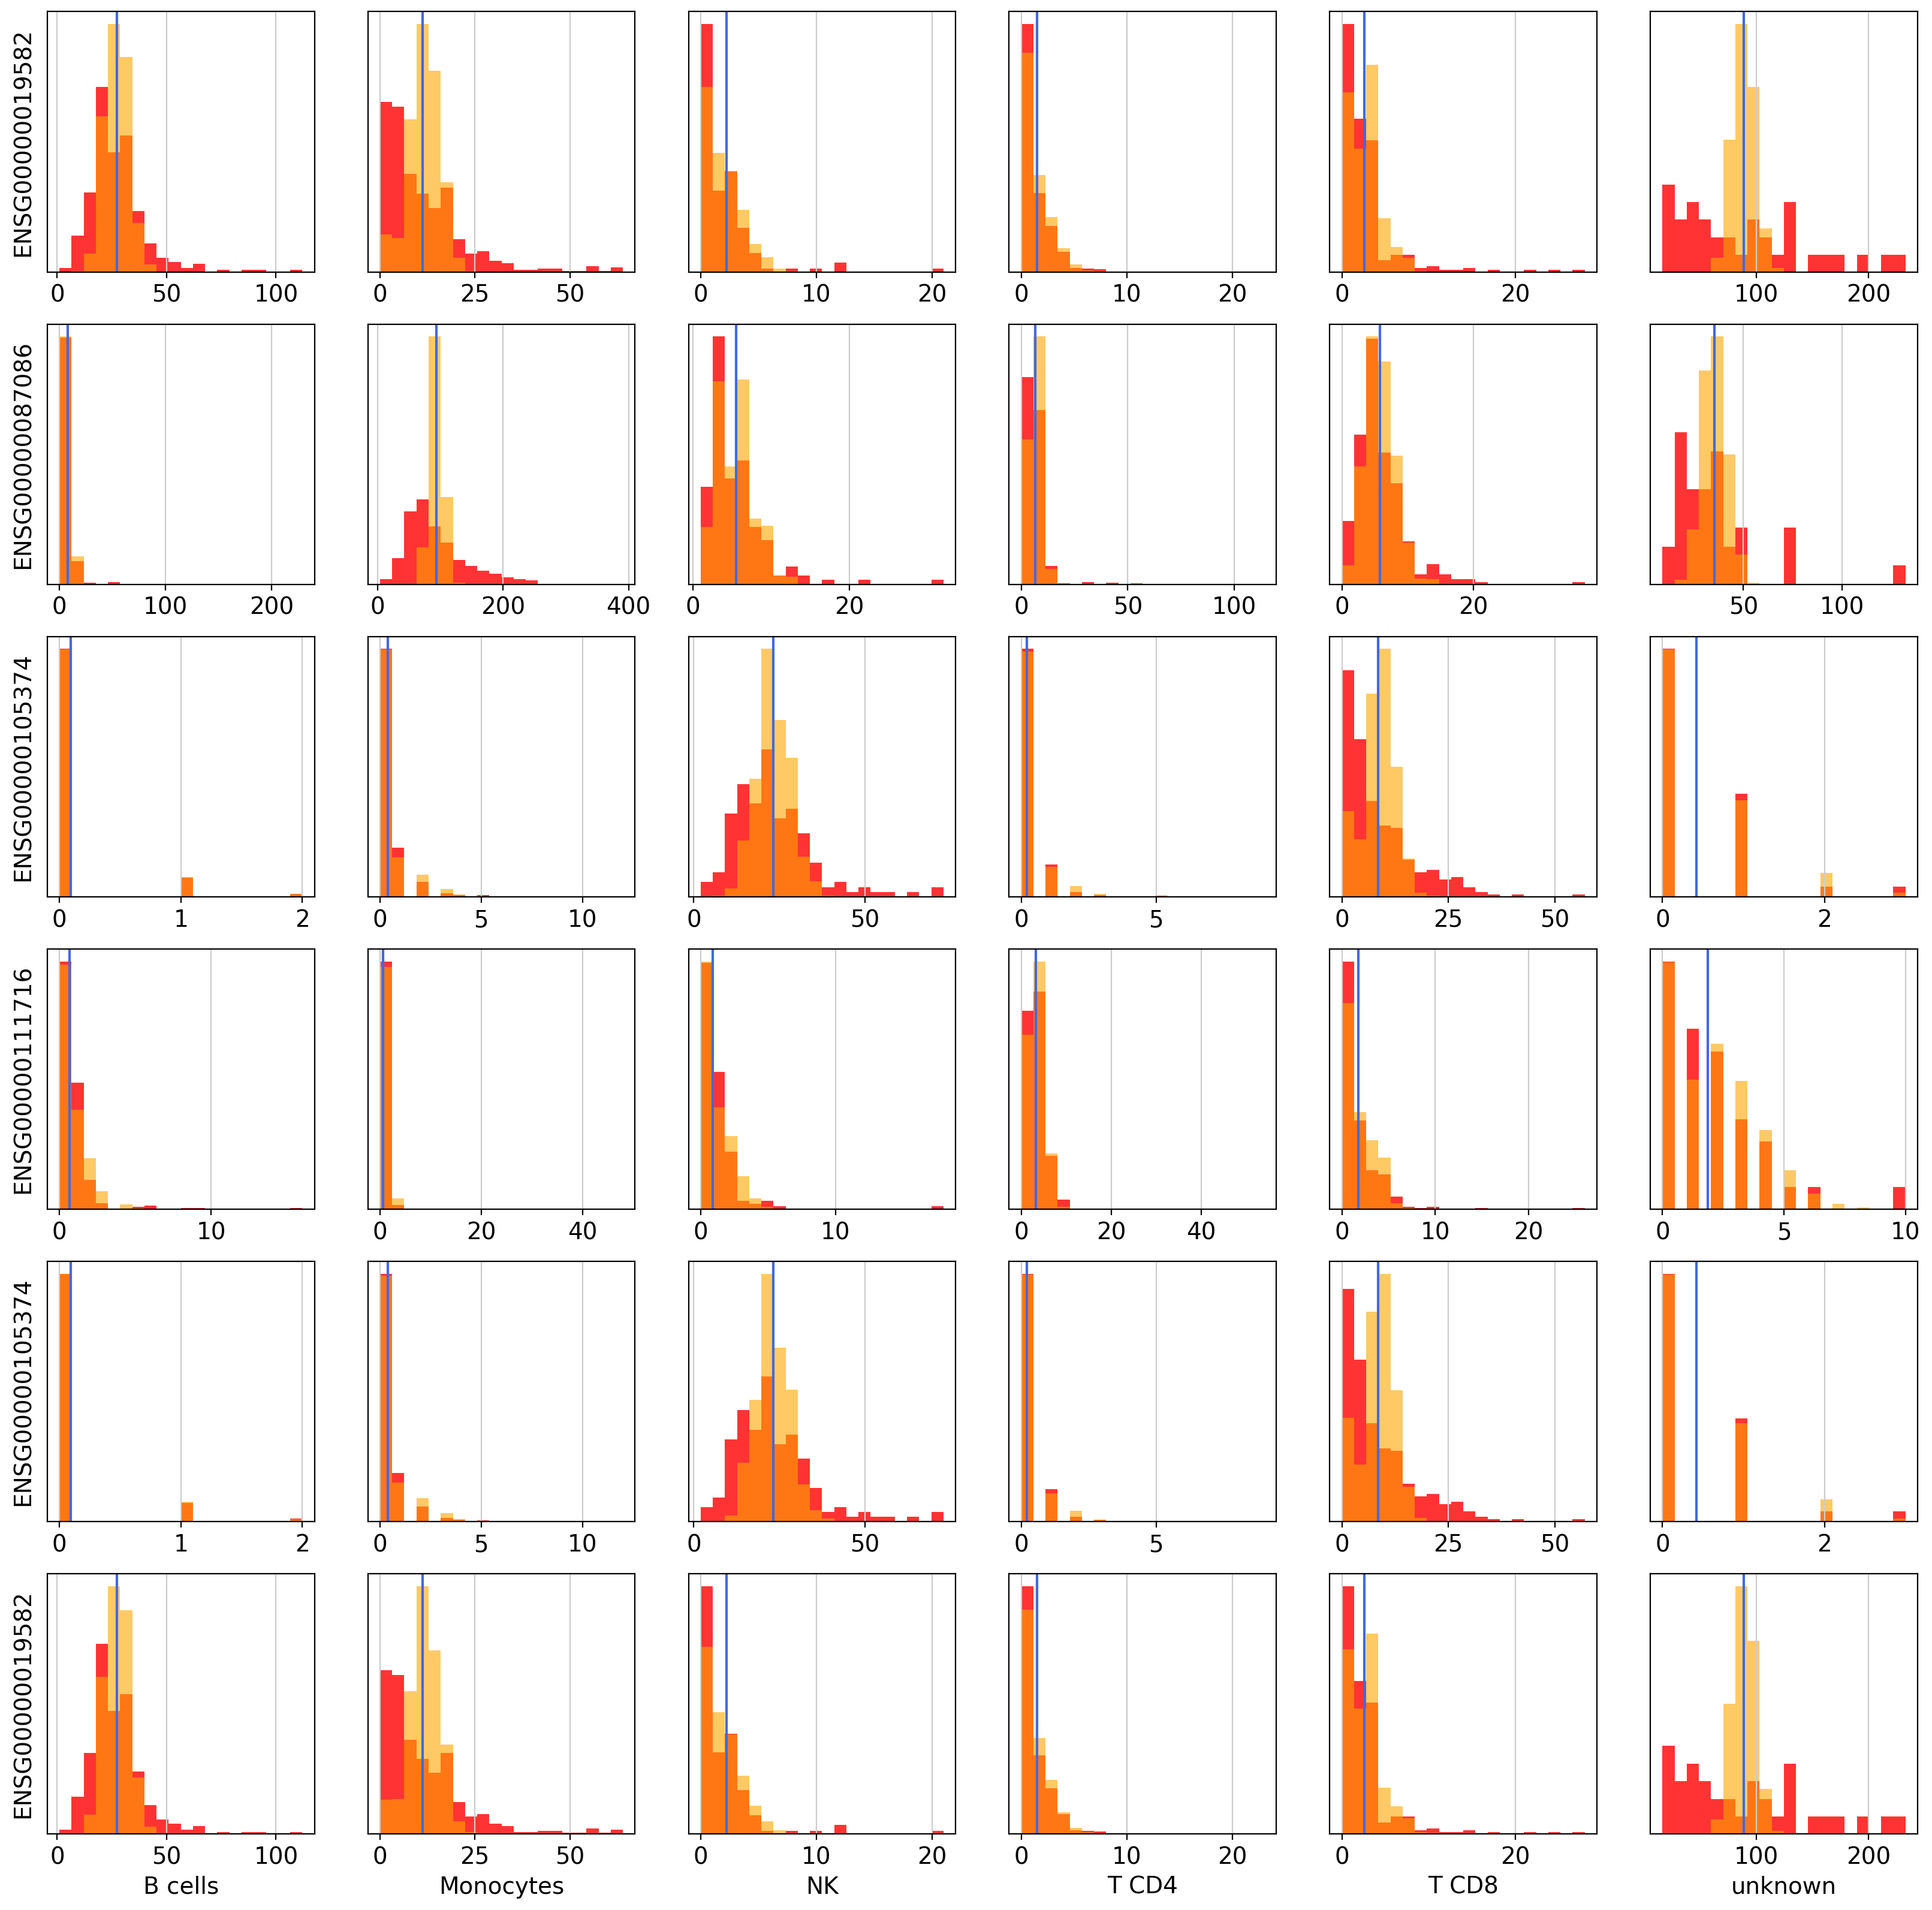

In [40]:
decon.check_fit()

In [41]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)

100%|██████████| 1000/1000 [00:03<00:00, 285.61it/s, loss=5.23e+07, lr=3.68e-02]


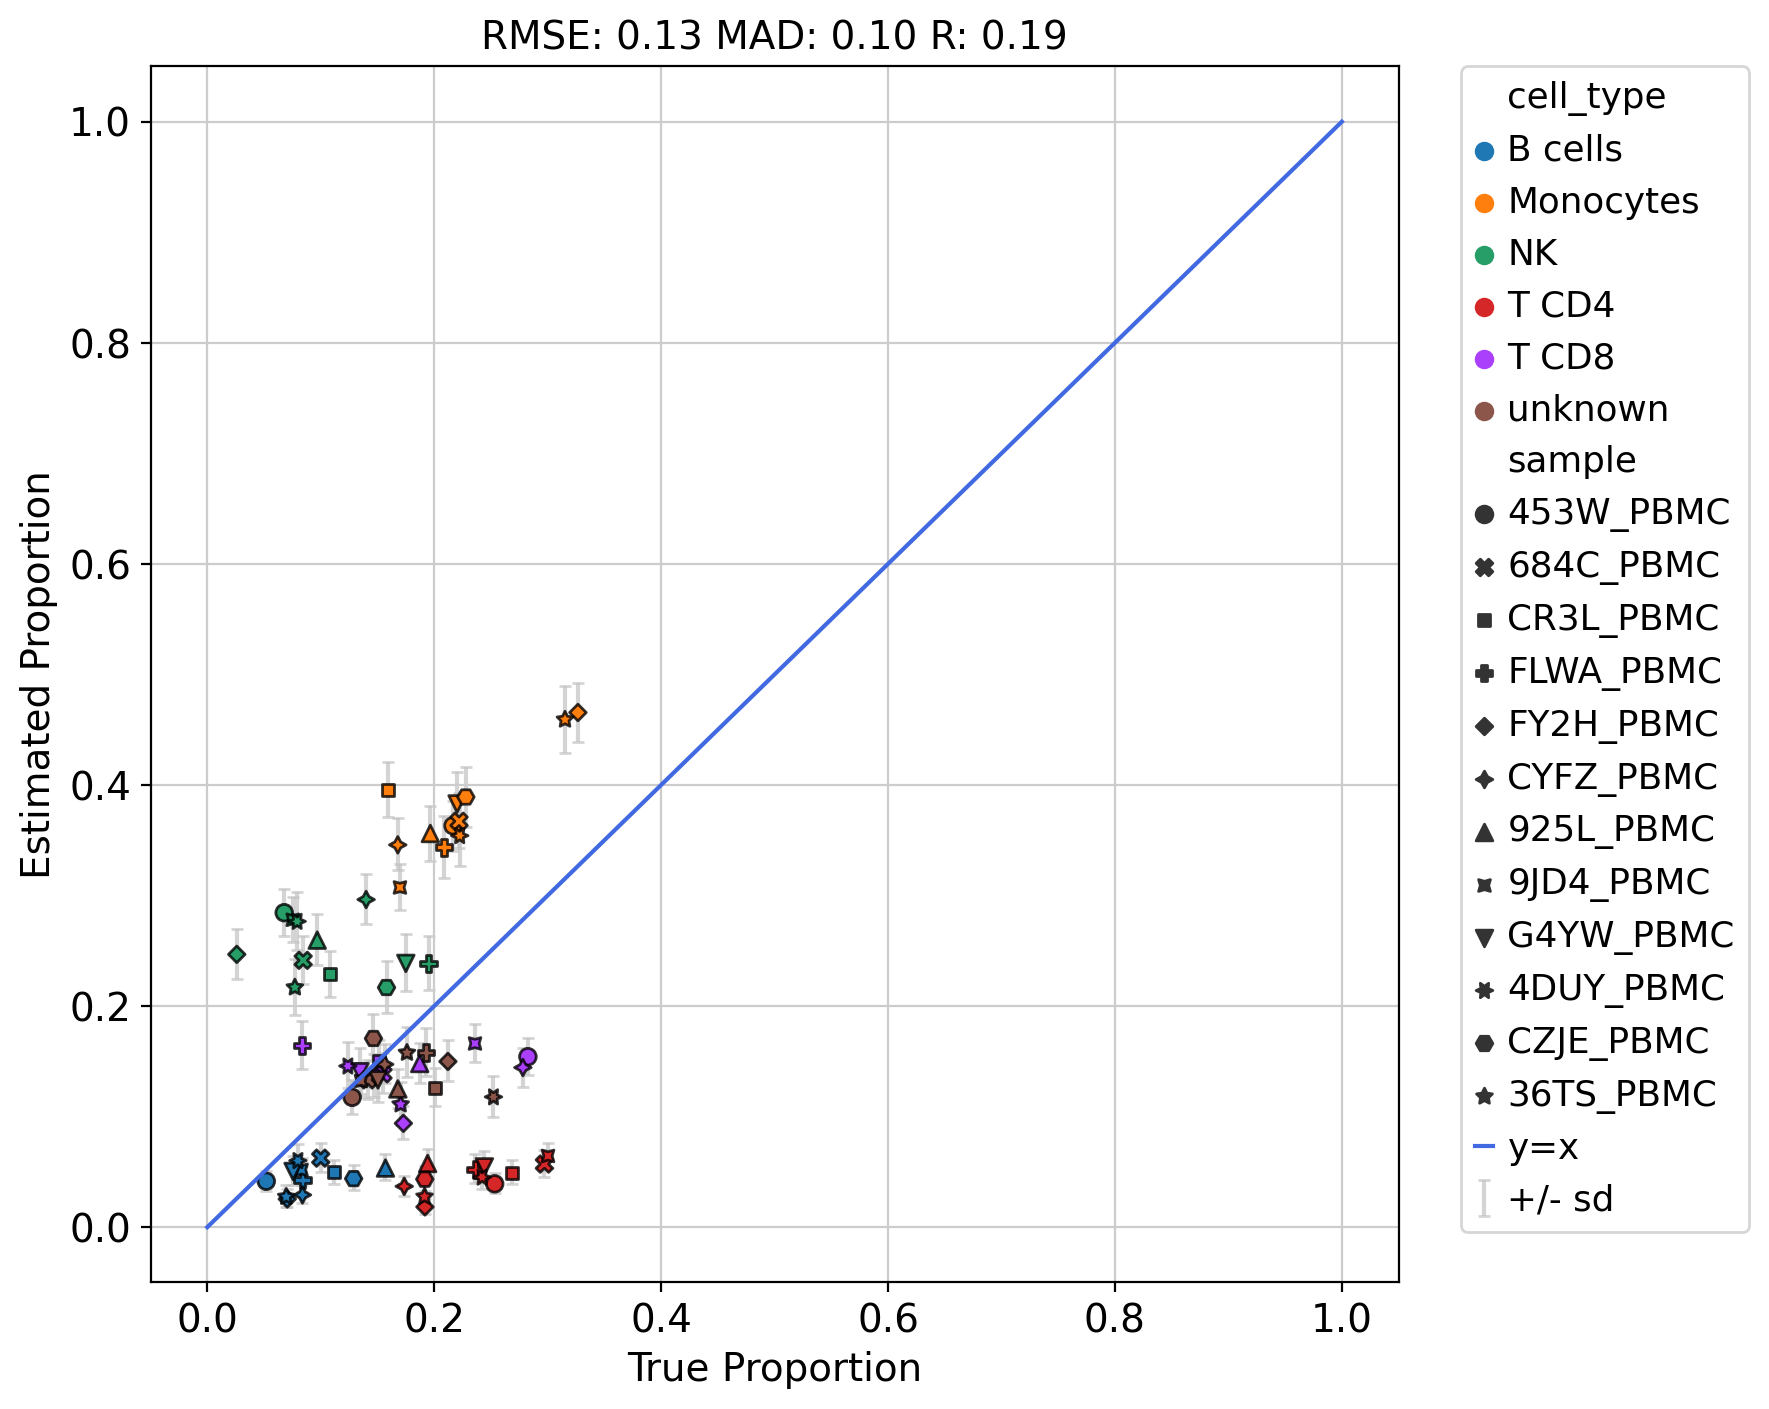

In [42]:
res_df = decon.get_results_df()
res_df["true"] = true_df.melt()["value"]
dv.pl.xypredictions(res_df)

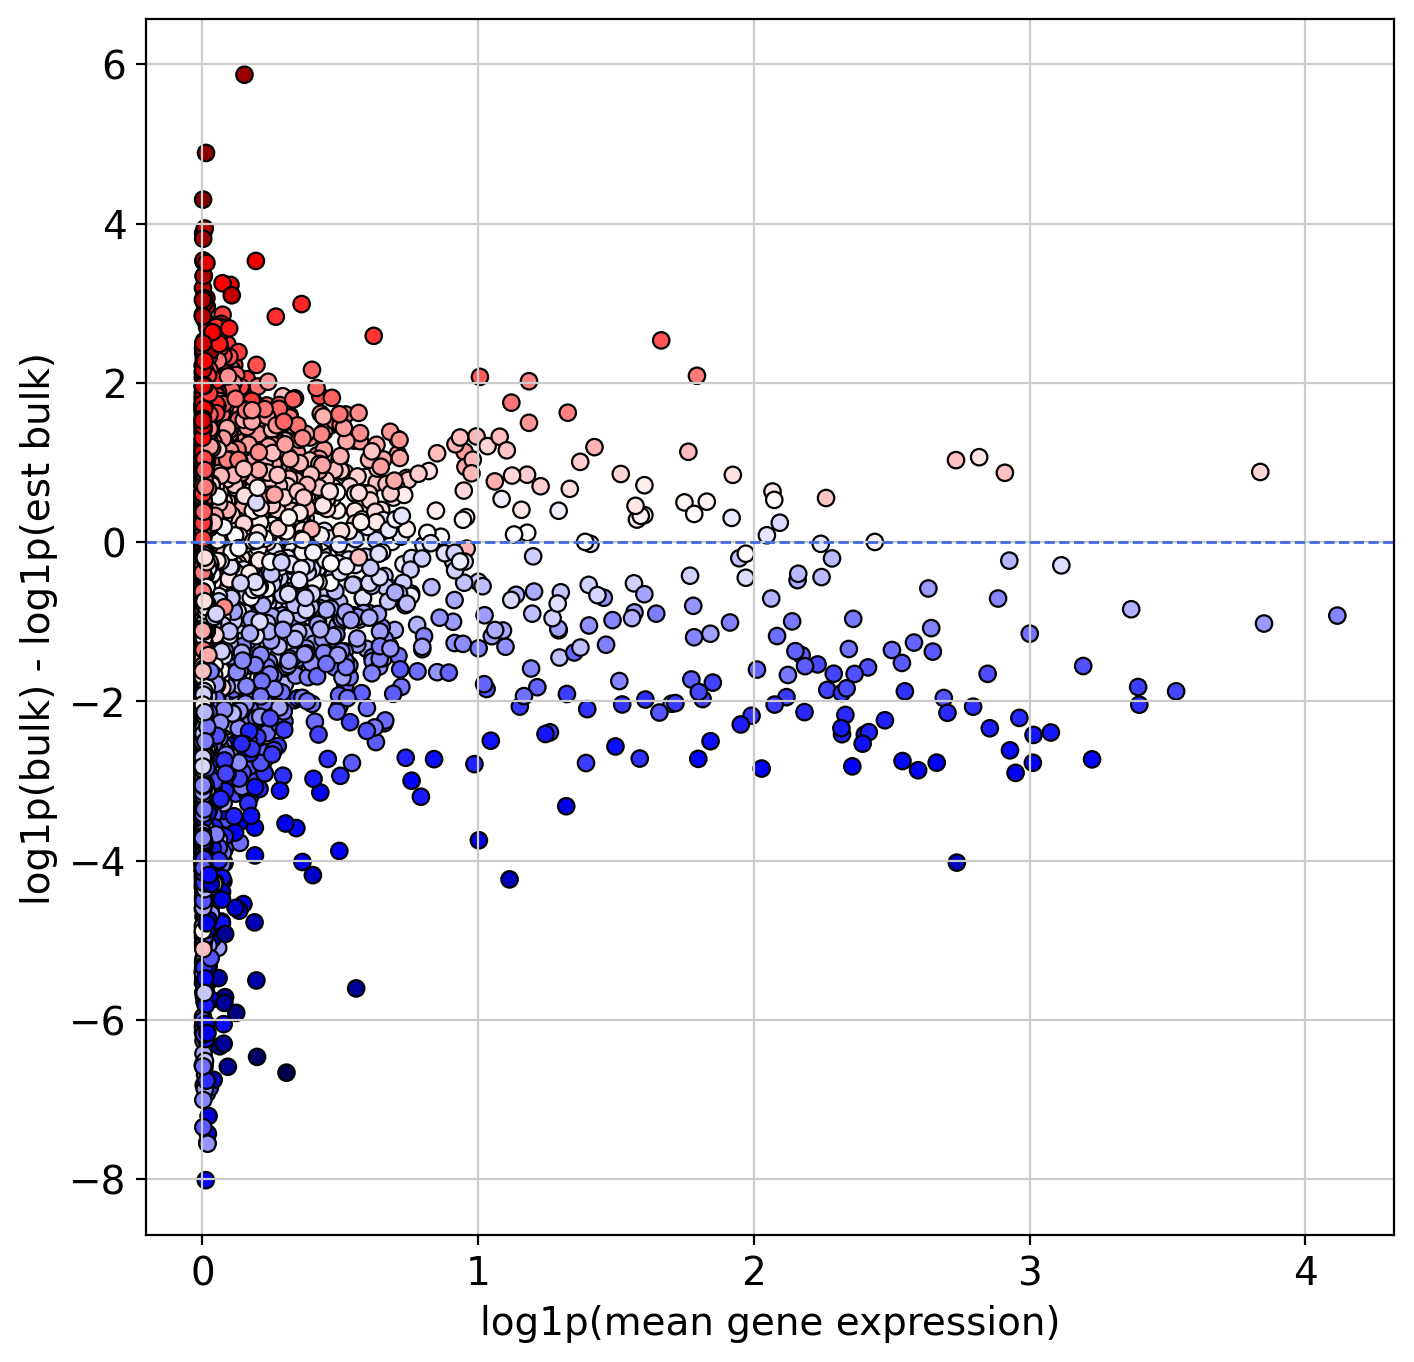

In [43]:
dv.pl.prediction_plot(decon, 0)